<img src="http://www.finanze.gov.it/export/system/modules/it.gov.finanze.template/resources/img/logo-mef.gif"  style="float: left; width: 25%; margin-left: 8%; margin-top: 0.5em;">

<img src="http://www.opencoesione.gov.it/static/img/header/testata.png" style="float: right; width: 42%; margin-right: 8%; margin-top: 1.6em;">

<p style="clear: both;">

# Studio a livello comunale sui finanziamenti a enti privati da dati OpenCoesione

### Finalità
Questo studio si propone come esempio delle seguenti opportunita' offerte dal Data Analytics Framework (DAF):
 - Integrare dati da fonti diverse permette di compiere analisi piu' complete in modo più semplice
 - L'impiego di strumenti open-source mette a disposizione tecniche di analisi molto avanzate, senza alcun costo di aggiornamento

### Dati e scopo dell'analisi
Questo notebook mette in relazione dati di spesa e raccolta IRPEF a livello comunale nel 2013 e dati sui finanziamenti con fondi di Coesione (FS, FSC e PAC) nel periodo 2007-2013. I due dataset sono:
######  OpenCivitas
http://www.opencivitas.it/open-data <br>
Riferimento ai campi usati: https://github.com/teamdigitale/daf-data-science/blob/master/opencivitas/analysis-opencivitas.ipynb

###### OpenCoesione 
http://www.opencoesione.gov.it/ <br>
Riferimento ai campi usati: http://www.opencoesione.gov.it/opendata/metadati_OC_2007_2013.xls

In [1]:
# python setup
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
import sklearn.cluster
from matplotlib import pyplot as plt

## Caricamento dataset da integrare

In [2]:
# --- Spese e redditi da OpenCivitas
speseERedditiComune = pd.read_csv('../opencivitas/data/opencivitas_spesa_storica_dati_irpef.csv') #dati per anno
speseERedditiComune = speseERedditiComune[~speseERedditiComune['Codice Istat Comune'].isna()]
speseERedditiComune['Codice Istat Regione'] = speseERedditiComune['Codice Istat Regione'].astype(int)

padZeros = np.vectorize(lambda x: str(x).rjust(6, '0')) # some utils
speseERedditiComune['Codice Istat Lungo'] = \
(speseERedditiComune['Codice Istat Regione'].astype(str) + padZeros(speseERedditiComune['Codice Istat Comune'].astype(int))).astype(int)

# --- Soggetti e luoghi da OpenCoesione
soggettiLuoghi = pd.read_csv('../pac_opencoesione/SoggettiELuoghi.csv', low_memory=False)
soggettiLuoghi.drop(columns=['SOGG_COD_RUOLO', 'SOGG_PROGR_RUOLO'], inplace=True)
soggettiLuoghi = soggettiLuoghi[~soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.isna()]
assert not any(soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].isna()), 'Unexpected missing codes'
soggettiLuoghi['COD_COMUNE_SEDE_SOGG'] = soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].astype(int)
soggettiLuoghi['COD_COMUNE_LUOGO'] = soggettiLuoghi['COD_COMUNE_LUOGO'].fillna(value=-1).astype(int)

## Integrazione OpenCoesione and OpenCivitas

#### Estrazione fondi erogati a soggetti privati per cui la sede e' riferibile ad un Comune:

In [3]:
bEntePrivato = soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.str.startswith('1') & \
                    (soggettiLuoghi.COD_COMUNE_SEDE_SOGG != -1)

soggLuoghiPrivato = soggettiLuoghi[bEntePrivato]
fondiSoggetti = soggLuoghiPrivato.groupby(
                    'COD_COMUNE_SEDE_SOGG')['TOT_PAGAMENTI'].sum().sort_values(ascending=False).to_frame()
fondiSoggetti = fondiSoggetti[fondiSoggetti >0]

#### In OpenCivitas non vi sono dati solo per le 15 regioni a Statuto ordinario: controlliamo quanto e' grande la quota di fondi in OpenCoesione riferita a sedi soggetto mancanti in OpenCivitas

In [4]:
listaComuniOpenCiv = speseERedditiComune['Codice Istat Lungo'].drop_duplicates()
listaRegioniOpenCiv = speseERedditiComune[['Codice Istat Regione', 'Regione']].drop_duplicates()
print(listaRegioniOpenCiv.set_index('Codice Istat Regione').sort_values('Regione'))
print('''
Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR %.4g, 
            di cui %.4g corrispondono a comuni in OpenCivitas) 
            
        ''' % (fondiSoggetti.sum(),
                fondiSoggetti[fondiSoggetti.index.isin(listaComuniOpenCiv.values)].sum()))

unioneComuniSoggetti = pd.merge(speseERedditiComune, fondiSoggetti,
                                how='left',left_on='Codice Istat Lungo', right_index = True)


                             Regione
Codice Istat Regione                
13                           ABRUZZO
17                        BASILICATA
18                          CALABRIA
15                          CAMPANIA
8                     EMILIA-ROMAGNA
12                             LAZIO
7                            LIGURIA
3                          LOMBARDIA
11                            MARCHE
14                            MOLISE
1                           PIEMONTE
16                            PUGLIA
9                            TOSCANA
10                            UMBRIA
5                             VENETO

Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR 1.359e+10, 
            di cui 1.222e+10 corrispondono a comuni in OpenCivitas) 
            
        


In [5]:
# Plot preparation
plt.rcParams["figure.figsize"] = (18,12)
#plt.rcParams.update({'font.size': 16})
sns.set_context("talk")
dataLog=unioneComuniSoggetti[unioneComuniSoggetti.ANNO==2013].copy()
dataLog['TOT_PAGAMENTI'] = np.log10(dataLog.TOT_PAGAMENTI)
dataLog['Numero contribuenti'] = np.log10(dataLog['Numero contribuenti'])
dataLog = dataLog[~dataLog['TOT_PAGAMENTI'].isna()]
#xLabelLog = 'Log della spesa totale del Comune nel 2013'
xLabelLog = 'Log del numero di contribuenti'
yLabelLog = 'Log Totale Pagamenti da fondi Coesione ad enti privati nel Comune'

#### Plot dei fondi ricevuti da enti privati rispetto al numero dei contribuenti nel Comune: <br> dispersione log-log con fit non parametrico ("lowess") e fit lineare per ciascuna Regione

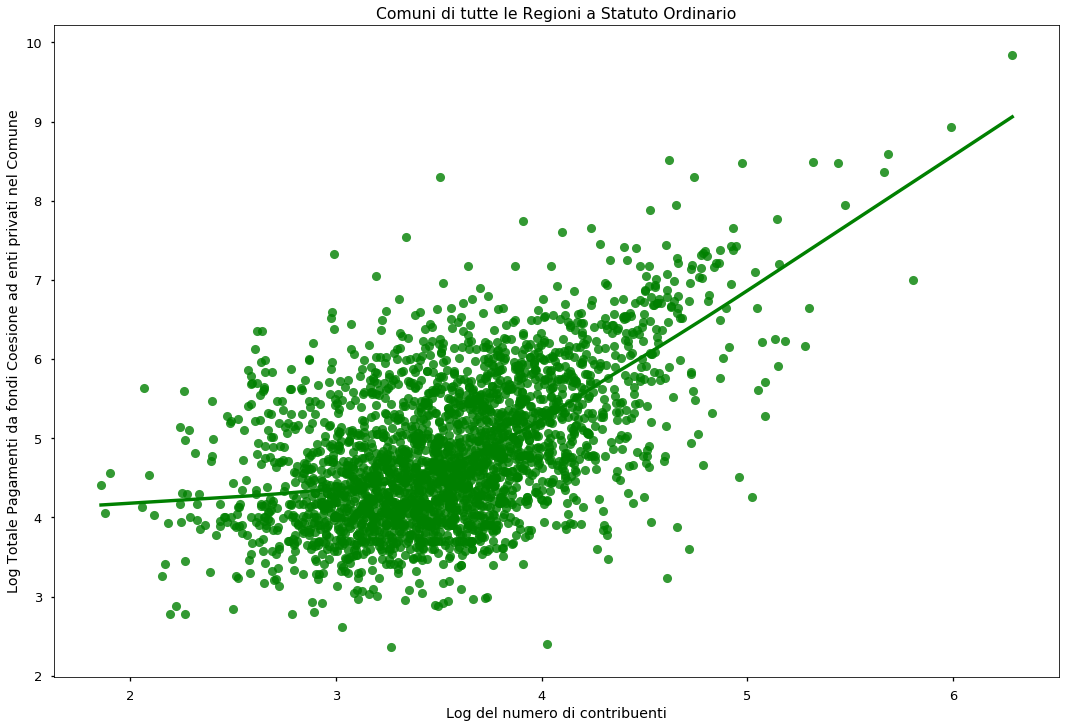

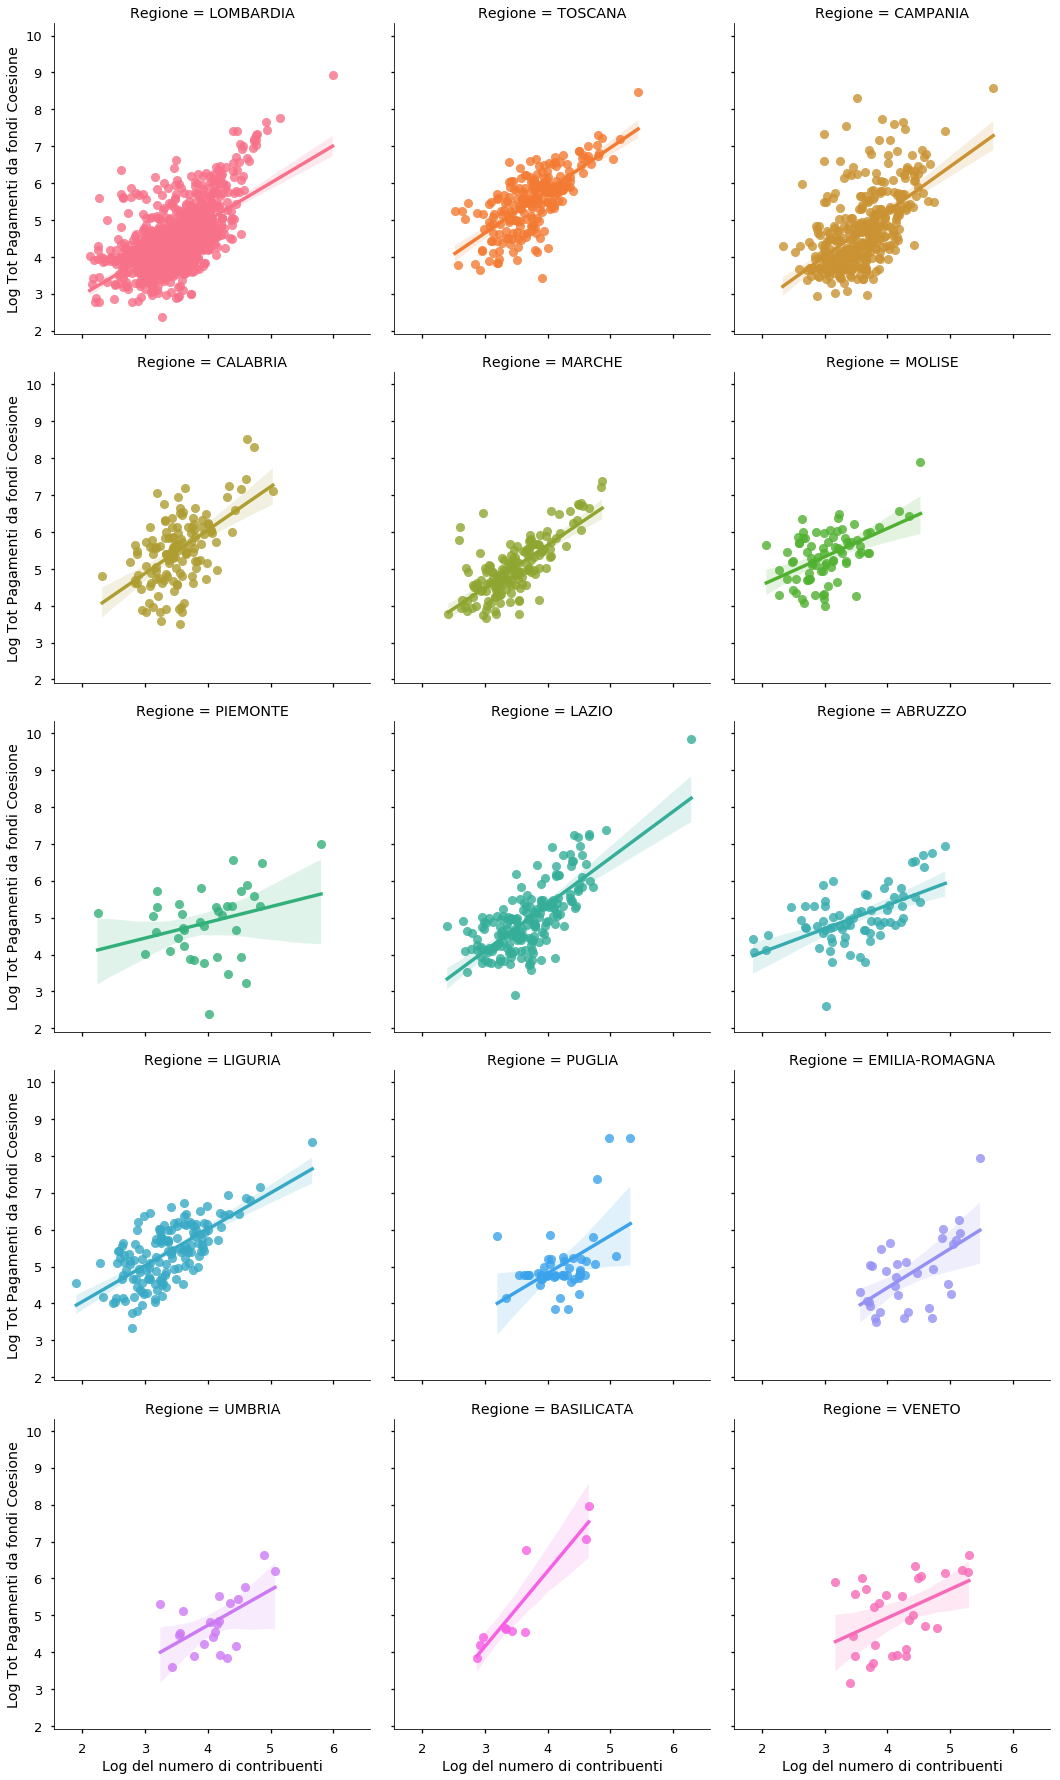

In [6]:
axAll = sns.regplot(x='Numero contribuenti', y='TOT_PAGAMENTI', data=dataLog, lowess=True, color = 'g')
axAll.set(xlabel =xLabelLog, ylabel=yLabelLog, title='Comuni di tutte le Regioni a Statuto Ordinario')
axSplit = sns.lmplot(x='Numero contribuenti', y='TOT_PAGAMENTI', data=dataLog, 
                    truncate=True, hue='Regione', col='Regione', col_wrap=3)
for ax in axSplit.axes:
    if ax.get_xlabel(): ax.set(xlabel=xLabelLog)
    if ax.get_ylabel(): ax.set(ylabel='Log Tot Pagamenti da fondi Coesione') 
plt.show()


Come si vede dai grafici, Comuni di diverse Regioni mostrano tendenze molto diverse rispetto all'accesso ai fondi di Coesione: possiamo provare a spiegare queste differenze in termini di caratteristiche del Comune stesso (redditi presenti, ripartizione della spesa)?

#### Clustering dei comuni per spesa

In [ ]:
# declare clustering variables
dataSpesa=unioneComuniSoggetti[unioneComuniSoggetti.ANNO==2013].copy()
spesaNames = [c for c in dataSpesa.columns if c.startswith('SPESA_CCC_F')]
spesaMedia = np.log10(dataSpesa[spesaNames].divide(
    dataSpesa['Numero contribuenti'], axis='index')+1)

spesaMediaNorm = spesaMedia.copy()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)) #MinMax rescaling
spesaMediaNorm[spesaNames] = scaler.fit_transform(spesaMedia[spesaNames])

In [82]:
sns.pairplot(spesaMediaNorm) #quite heavy to plot
plt.show()

KeyboardInterrupt: 

In [13]:
#from sklearn.cluster.KMeans
# find the best number of clusters

nClusters = np.arange(5,30)

def evaluate_errors(testClusters, data):
    errValue = np.zeros_like(testClusters)
    for i, k in enumerate(testClusters):
        Clusterer = sklearn.cluster.KMeans(n_clusters=k)
        Clusterer.fit(data)
        errValue[i] = Clusterer.inertia_
    return errValue

errValueNorm = evaluate_errors(nClusters, spesaMediaNorm)

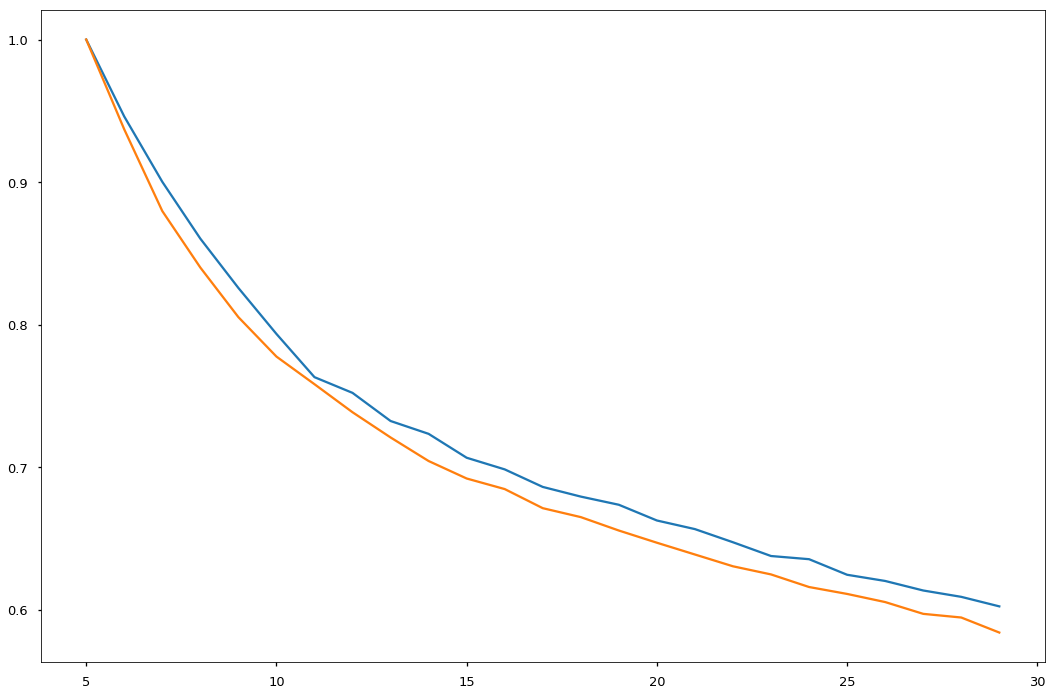

In [14]:
plt.plot(nClusters, errValueNorm/errValueNorm.max())
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6640 samples in 0.011s...
[t-SNE] Computed neighbors for 6640 samples in 1.753s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6640
[t-SNE] Computed conditional probabilities for sample 2000 / 6640
[t-SNE] Computed conditional probabilities for sample 3000 / 6640
[t-SNE] Computed conditional probabilities for sample 4000 / 6640
[t-SNE] Computed conditional probabilities for sample 5000 / 6640
[t-SNE] Computed conditional probabilities for sample 6000 / 6640
[t-SNE] Computed conditional probabilities for sample 6640 / 6640
[t-SNE] Mean sigma: 0.168305
[t-SNE] Computed conditional probabilities in 0.813s
[t-SNE] Iteration 50: error = 29.4236202, gradient norm = 0.0190627 (50 iterations in 11.603s)
[t-SNE] Iteration 100: error = 26.6654320, gradient norm = 0.0006813 (50 iterations in 10.033s)
[t-SNE] Iteration 150: error = 26.3989048, gradient norm = 0.0003369 (50 iterations in 10.124s)
[t-SNE] Iteration 200: error

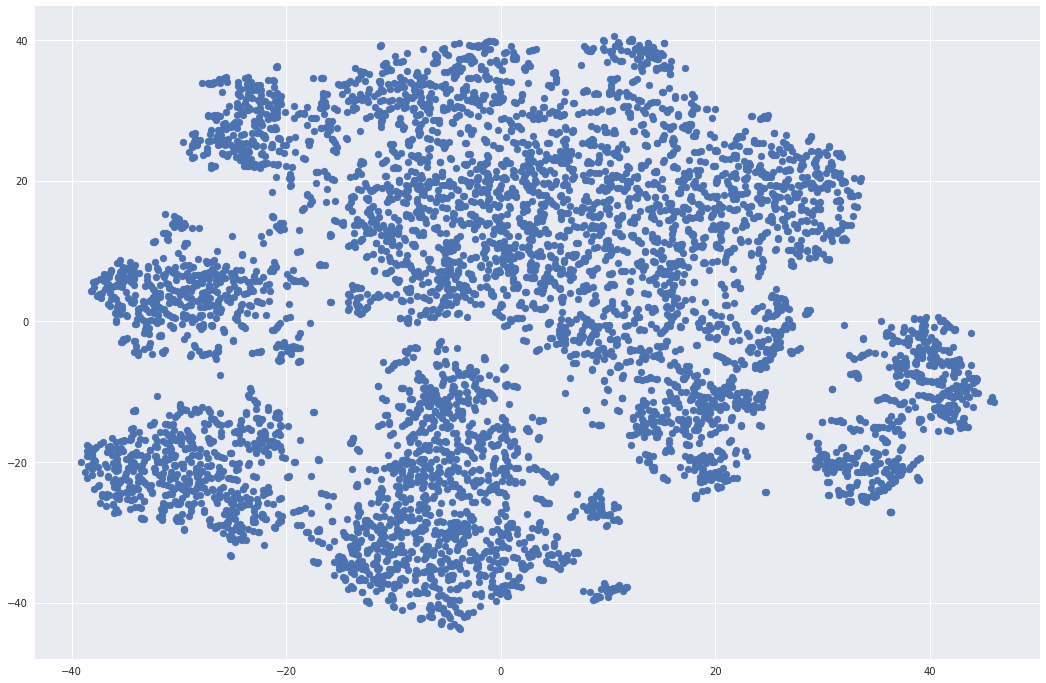

In [91]:
fitter_tSNE = sklearn.manifold.TSNE(n_components=2,verbose=2,
                                    n_iter=600, early_exaggeration=5,learning_rate=120)

fitter_tSNE.fit(spesaMediaNorm)

X_embedded = fitter_tSNE.embedding_
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

Abbiamo visto che K-means suggerisce vi siano 11 clusters nei dati. Fittiamo i clusters nella versione 2D dei dati prodotta da t-SNE.

In [95]:
targetNClusters = 7

Clusterer = sklearn.cluster.KMeans(n_clusters=targetNClusters,n_init=20)
Clusterer = sklearn.cluster.AgglomerativeClustering(n_clusters=targetNClusters)
Clusterer = sklearn.cluster.DBSCAN(eps=2.5)
Clusterer.fit(X_embedded)
spesaMedia['cluster'] = Clusterer.labels_
spesaMedia['x_tsne']= X_embedded[:,0]
spesaMedia['y_tsne']= X_embedded[:,1]

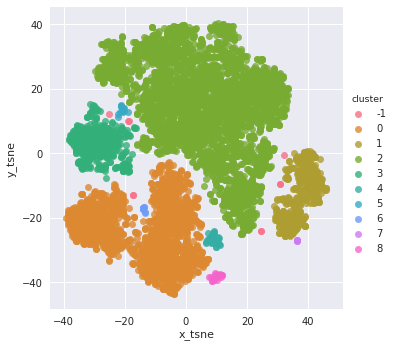

In [96]:
sns.lmplot(x='x_tsne', y='y_tsne',hue='cluster', data=spesaMedia, fit_reg=False)
plt.show()

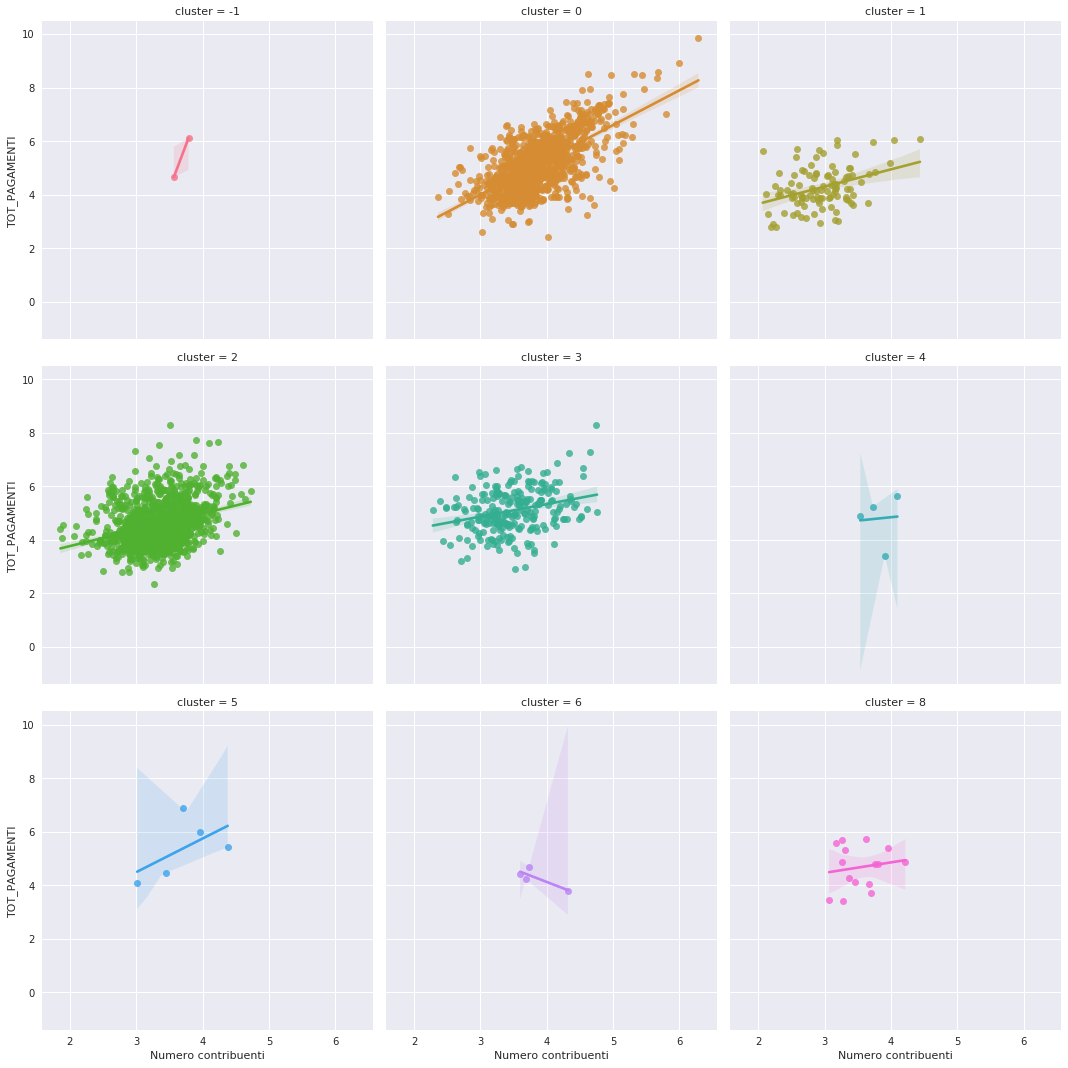

In [97]:
dataLog['cluster'] = spesaMedia['cluster']
axSplit = sns.lmplot(x='Numero contribuenti', y='TOT_PAGAMENTI', data=dataLog, 
                    truncate=True, hue='cluster', col='cluster', col_wrap=3)

In [ ]:
spesaMediaLin = np.log10(dataSpesa[spesaNames].divide(
    dataSpesa['Numero contribuenti'], axis='index')+1)

X_embedded = fitter_tSNE(n_components=2).fit_transform(spesaMediaLin)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()